# LSTM

### LSTM(+ One-hot Encoding)

### 데이터 준비

In [6]:
from tensorflow.keras.datasets import imdb
import torch
import torch.nn.functional as F

VOCAB_SIZE = 300 # 사용할 단어 수
SEQ_LEN = 150    # 시퀀스 하나의 최대 길이

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

# Torch Tensor 변환
train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input][:10000] 
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input][:5000] 

train_target = torch.tensor(train_target, dtype=torch.long)[:10000]
test_target = torch.tensor(test_target, dtype=torch.long)[:5000]

def pad_sequences(sequences, maxlen, padding_value=0):
    padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
    return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

train_onehot.shape, test_onehot.shape

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


(torch.Size([10000, 150, 300]), torch.Size([5000, 150, 300]))

### 학습 함수 정의

In [7]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

def train_func(train_data, train_label, model):

    # 배치 사이즈, 학습/검증셋 크기 설정
    BATCH_SIZE = 65
    train_size = int(len(train_data) * 0.8)
    val_size = len(train_data) - train_size



    # 데이터 학습/검증셋 분할
    train_dataset, val_dataset = random_split(TensorDataset(train_data, train_label), [train_size, val_size])
    # 미니배치로 사용할 수 있도록 DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # epoch(학습 횟수), 손실 함수, 최적화 함수 정의
    epochs = 100
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    # 시각화를 위한 손실값/정확도 저장용 배열 생성
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # 조기종료 관련 변수 초기화
    early_stopping_patience = 7
    best_val_loss = float('inf')
    early_stop_counter = 0

    # 학습 과정
    for epoch in range(epochs):
        # 학습 모드
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()               # 가중치 초기화
            outputs = model(inputs).squeeze()   # 순전파

            loss = criterion(outputs, targets)  # 손실 계산

            loss.backward()                     # 역전파
            optimizer.step()                    # 가중치 갱신
            total_loss += loss.item()

            pred = (outputs > 0.5).float()
            correct += (pred == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
            
        # 검증 모드
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs).squeeze()   # 순전파
                loss = criterion(val_outputs, val_targets)  # 손실 계산
                val_loss += loss.item()

                val_pred = (val_outputs > 0.5).float()
                val_correct += (val_pred == val_targets).sum().item()
                val_total += val_targets.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)    

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # 조기종료 처리
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print("Early stopping!!!")
                break

    train_history_df = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_accs': val_accs
    })

    train_history_df.plot()
    plt.show()

### 평가 함수 정의

In [8]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_inputs, val_targets in test_loader:
            val_outputs = model(val_inputs).squeeze()   # 순전파
            loss = criterion(val_outputs, val_targets)  # 손실 계산
            val_loss += loss.item()

            val_pred = (val_outputs > 0.5).float()
            val_correct += (val_pred == val_targets).sum().item()
            val_total += val_targets.size(0)

    test_loss = val_loss / len(test_loader)
    test_acc = val_correct / val_total
    return test_loss, test_acc
  

### 모델 준비 및 학습

### LSTM

In [9]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):

    def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)

In [10]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

lstm_model = SentimentLSTM(
    seq_len=SEQ_LEN,
    vocab_size= VOCAB_SIZE,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(lstm_model)

SentimentLSTM(
  (lstm): LSTM(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6934, Train Acc: 0.5100, Val Loss: 0.6928, Val Acc: 0.5130
Epoch 2/100 | Train Loss: 0.6911, Train Acc: 0.5261, Val Loss: 0.6926, Val Acc: 0.5160
Epoch 3/100 | Train Loss: 0.6851, Train Acc: 0.5551, Val Loss: 0.6776, Val Acc: 0.5765
Epoch 4/100 | Train Loss: 0.6862, Train Acc: 0.5595, Val Loss: 0.6918, Val Acc: 0.5170
Epoch 5/100 | Train Loss: 0.6755, Train Acc: 0.5824, Val Loss: 0.6819, Val Acc: 0.5560
Epoch 6/100 | Train Loss: 0.6633, Train Acc: 0.5931, Val Loss: 0.6656, Val Acc: 0.6115
Epoch 7/100 | Train Loss: 0.6871, Train Acc: 0.5556, Val Loss: 0.6938, Val Acc: 0.4930
Epoch 8/100 | Train Loss: 0.6801, Train Acc: 0.5501, Val Loss: 0.6938, Val Acc: 0.5175
Epoch 9/100 | Train Loss: 0.6676, Train Acc: 0.5965, Val Loss: 0.6986, Val Acc: 0.5060
Epoch 10/100 | Train Loss: 0.6913, Train Acc: 0.5228, Val Loss: 0.6938, Val Acc: 0.5125
Epoch 11/100 | Train Loss: 0.6844, Train Acc: 0.5404, Val Loss: 0.6932, Val Acc: 0.5140
Epoch 12/100 | Train Loss: 0.6805, Train 

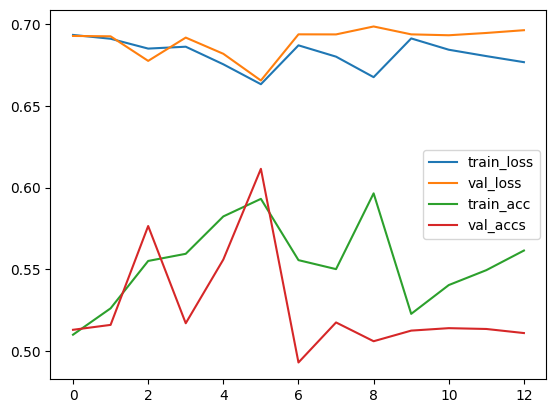

In [11]:
train_func(train_onehot, train_target, lstm_model)

In [12]:
test_dataset = TensorDataset(test_onehot, test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(lstm_model, test_loader, criterion)
loss, accuracy

(0.6970968780579505, 0.5154)

### LSTM (+ Embedding)

In [13]:
import torch
import torch.nn as nn

class EBDSentimentLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(EBDSentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)

In [14]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50


ebd_lstm_model = EBDSentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(ebd_lstm_model)

EBDSentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm): LSTM(50, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6947, Train Acc: 0.5039, Val Loss: 0.6926, Val Acc: 0.5015
Epoch 2/100 | Train Loss: 0.6908, Train Acc: 0.5294, Val Loss: 0.6912, Val Acc: 0.5175
Epoch 3/100 | Train Loss: 0.6842, Train Acc: 0.5509, Val Loss: 0.6933, Val Acc: 0.5265
Epoch 4/100 | Train Loss: 0.6727, Train Acc: 0.5785, Val Loss: 0.6826, Val Acc: 0.5850
Epoch 5/100 | Train Loss: 0.6417, Train Acc: 0.6350, Val Loss: 0.6499, Val Acc: 0.6350
Epoch 6/100 | Train Loss: 0.6050, Train Acc: 0.6796, Val Loss: 0.6171, Val Acc: 0.6745
Epoch 7/100 | Train Loss: 0.5726, Train Acc: 0.7181, Val Loss: 0.6084, Val Acc: 0.6890
Epoch 8/100 | Train Loss: 0.5483, Train Acc: 0.7320, Val Loss: 0.6328, Val Acc: 0.6640
Epoch 9/100 | Train Loss: 0.5252, Train Acc: 0.7449, Val Loss: 0.6120, Val Acc: 0.6840
Epoch 10/100 | Train Loss: 0.5194, Train Acc: 0.7540, Val Loss: 0.6537, Val Acc: 0.6760
Epoch 11/100 | Train Loss: 0.5072, Train Acc: 0.7646, Val Loss: 0.6116, Val Acc: 0.6985
Epoch 12/100 | Train Loss: 0.4966, Train 

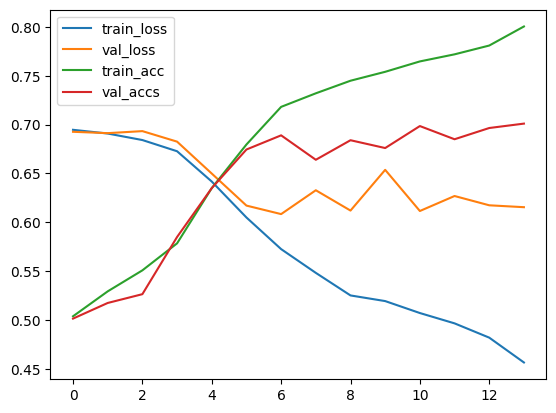

In [15]:
train_func(train_seq.to(torch.long), train_target, ebd_lstm_model)

In [16]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(ebd_lstm_model, test_loader, criterion)
loss, accuracy

(0.6423859131800664, 0.6934)

### Stacked LSTM (Embedding + LSTM + LSTM)

In [ ]:
class StackedSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        1
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=embedding_dim)
        self.lstm1 = nn.LSTM(input_size=embedding_dim, 
                             hidden_size=hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim, 
                             hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        _, (hidden, _) = self.lstm2(x)
        out = self.fc(hidden)
        return self.sigmoid(out) 

In [18]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50


stacked_lstm_model = StackedSentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(stacked_lstm_model)

StackedSentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm1): LSTM(50, 8, batch_first=True)
  (lstm2): LSTM(8, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6937, Train Acc: 0.5059, Val Loss: 0.6923, Val Acc: 0.5480
Epoch 2/100 | Train Loss: 0.6875, Train Acc: 0.5413, Val Loss: 0.6716, Val Acc: 0.5950
Epoch 3/100 | Train Loss: 0.6612, Train Acc: 0.6048, Val Loss: 0.6537, Val Acc: 0.6305
Epoch 4/100 | Train Loss: 0.6303, Train Acc: 0.6596, Val Loss: 0.7366, Val Acc: 0.5550
Epoch 5/100 | Train Loss: 0.6206, Train Acc: 0.6695, Val Loss: 0.6115, Val Acc: 0.6815
Epoch 6/100 | Train Loss: 0.5755, Train Acc: 0.7205, Val Loss: 0.6053, Val Acc: 0.6860
Epoch 7/100 | Train Loss: 0.5537, Train Acc: 0.7304, Val Loss: 0.5952, Val Acc: 0.6955
Epoch 8/100 | Train Loss: 0.5490, Train Acc: 0.7362, Val Loss: 0.5936, Val Acc: 0.7010
Epoch 9/100 | Train Loss: 0.5348, Train Acc: 0.7512, Val Loss: 0.6009, Val Acc: 0.6900
Epoch 10/100 | Train Loss: 0.5316, Train Acc: 0.7512, Val Loss: 0.6011, Val Acc: 0.6985
Epoch 11/100 | Train Loss: 0.5101, Train Acc: 0.7685, Val Loss: 0.5898, Val Acc: 0.7045
Epoch 12/100 | Train Loss: 0.5130, Train 

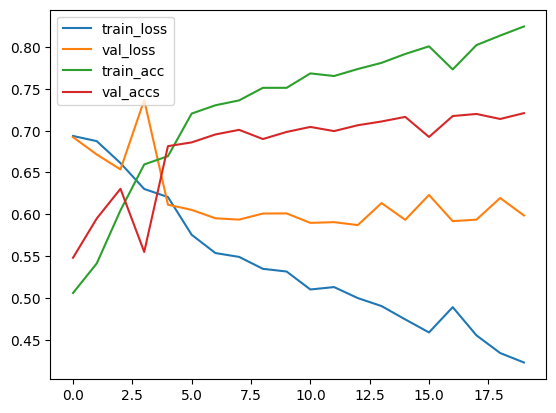

In [19]:
train_func(train_seq.to(torch.long), train_target, stacked_lstm_model)

In [20]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(stacked_lstm_model, test_loader, criterion)
loss, accuracy

(0.6221314691877985, 0.7074)

### Stacked LSTM (Embedding + LSTM + LSTM + Dropout)

In [21]:
class StackedDOSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(StackedDOSentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=embedding_dim)
        self.lstm1 = nn.LSTM(input_size=embedding_dim, 
                             hidden_size=hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.lstm2 = nn.LSTM(input_size=hidden_dim, 
                             hidden_size=hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        _, (hidden, _) = self.lstm2(x)
        x = self.dropout2(hidden)
        out = self.fc(x)
        return self.sigmoid(out) 

In [22]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50
DROPOUT_RATE = 0.3


stacked_do_lstm_model = StackedDOSentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout_rate=DROPOUT_RATE
)

print(stacked_do_lstm_model)

StackedDOSentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm1): LSTM(50, 8, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(8, 8, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6942, Train Acc: 0.5036, Val Loss: 0.6934, Val Acc: 0.4980
Epoch 2/100 | Train Loss: 0.6910, Train Acc: 0.5225, Val Loss: 0.6905, Val Acc: 0.5230
Epoch 3/100 | Train Loss: 0.6857, Train Acc: 0.5444, Val Loss: 0.6892, Val Acc: 0.5395
Epoch 4/100 | Train Loss: 0.6559, Train Acc: 0.6210, Val Loss: 0.6429, Val Acc: 0.6320
Epoch 5/100 | Train Loss: 0.6050, Train Acc: 0.6870, Val Loss: 0.6052, Val Acc: 0.6895
Epoch 6/100 | Train Loss: 0.5694, Train Acc: 0.7235, Val Loss: 0.5652, Val Acc: 0.7220
Epoch 7/100 | Train Loss: 0.5346, Train Acc: 0.7482, Val Loss: 0.5590, Val Acc: 0.7320
Epoch 8/100 | Train Loss: 0.5140, Train Acc: 0.7659, Val Loss: 0.5472, Val Acc: 0.7455
Epoch 9/100 | Train Loss: 0.4967, Train Acc: 0.7821, Val Loss: 0.5454, Val Acc: 0.7435
Epoch 10/100 | Train Loss: 0.4802, Train Acc: 0.7897, Val Loss: 0.5417, Val Acc: 0.7390
Epoch 11/100 | Train Loss: 0.4695, Train Acc: 0.7951, Val Loss: 0.5395, Val Acc: 0.7415
Epoch 12/100 | Train Loss: 0.4492, Train 

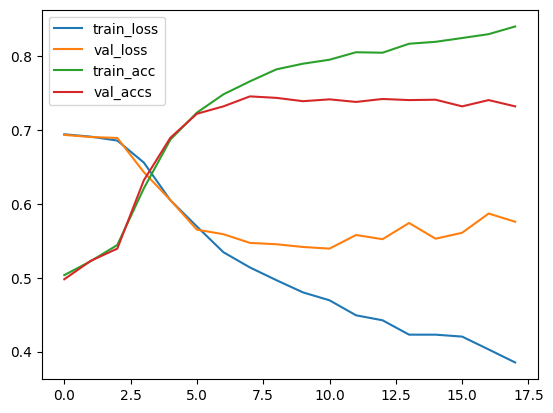

In [23]:
train_func(train_seq.to(torch.long), train_target, stacked_do_lstm_model)

In [24]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(stacked_do_lstm_model, test_loader, criterion)
loss, accuracy

(0.5885058684008462, 0.7216)